# Information maximiser

Using neural networks, sufficient statistics can be obtained from data by maximising the Fisher information.

The neural network takes some data ${\bf d}$ and maps it to a compressed summary $\mathscr{f}:{\bf d}\to{\bf x}$ where ${\bf x}$ can have the same size as the dimensionality of the parameter space, rather than the data space.

To train the neural network a batch of simulations ${\bf d}_{\sf sim}^{\sf fid}$ created at a fiducial parameter value $\boldsymbol{\theta}^{\rm fid}$ are compressed by the neural network to obtain ${\bf x}_{\sf sim}^{\sf fid}$. From this we can calculate the covariance ${\bf C_\mathscr{f}}$ of the compressed summaries. We also use simulations ${\bf d}_{\sf sim}^{\sf fid+}$ created above the fiducial parameter value $\boldsymbol{\theta}^{\sf fid+}$ and simulations ${\bf d}_{\sf sim}^{\sf fid-}$ created below the fiducial parameter value $\boldsymbol{\theta}^{\sf fid-}$. These are compressed using the network and used to find mean of the summaries $\partial\boldsymbol{\mu}_\mathscr{f}/\partial\theta_\alpha\equiv\boldsymbol{\mu}_\mathscr{f},_\alpha$ where the numerical derivative is $({\bf x}_{\sf sim}^{\sf fid+}-{\bf x}_{\sf sim}^{\sf fid-})/(\boldsymbol{\theta}^{\sf fid+}-\boldsymbol{\theta}^{\sf fid-})$. We then use ${\bf C}_\mathscr{f}$ and $\boldsymbol{\mu}_\mathscr{f},_\alpha$ to calculate the Fisher information
$${\bf F}_{\alpha\beta} = \boldsymbol{\mu}_\mathscr{f},^T_{\alpha}{\bf C}^{-1}_\mathscr{f}\boldsymbol{\mu}_\mathscr{f},_{\beta}.$$
We want to maximise the Fisher information so to train the network we use the loss function
$$\Lambda = -\frac{1}{2}|{\bf F}_{\alpha\beta}|.$$

When using this code please cite <a href="https://arxiv.org/abs/1802.03537">arXiv:1802.03537</a>.<br><br>
The code in the paper can be downloaded as v1 or v1.1 of the code kept on zenodo:<br><br>
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1175196.svg)](https://doi.org/10.5281/zenodo.1175196)
<br>
The code presented below is version two (and is much more powerful) and is under constant development.

This code is run using<br>
>`python-3.6.6`

>`jupyter-4.4.0`

>`tensorflow-1.10.1`

>`numpy-1.14.5`

>`tqdm==4.25.0`

>`sys (native)`

Although these precise versions may not be necessary, I have put them here to avoid possible conflicts. 

## Load modules

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IMNN

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Generate data
In this example we are going to use $n_{\bf d}=10$ data points of a 1D field of Gaussian noise with zero mean and unknown variance to see if the network can learn to summarise this variance.<br><br>
We start by defining a function to generate the data with the correct shape. The shape must be
```
data_shape = None + input shape
```

In [2]:
input_shape = [10]

It is useful to define the generating function so that it only takes in the value of the parameter as its input since the function can then be used for ABC later.<br><br>
The data needs to be generated at a fiducial parameter value and at perturbed values just below and above the fiducial parameter for the numerical derivative. 

In [3]:
θ_fid = 1.
Δθpm = 0.1

The data at the perturbed values should have the shape
```
perturbed_data_shape = None + number of parameters + input shape
```

The generating function is defined so that the fiducial parameter is passed as a list so that many simulations can be made at once. This is very useful for the ABC function later.

In [4]:
def generate_data(θ, train = False):
    if train:
        return np.moveaxis(np.random.normal(0., np.sqrt(θ), [1] + input_shape + [len(θ)]), -1, 0)
    else:
        return np.moveaxis(np.random.normal(0., np.sqrt(θ), input_shape + [len(θ)]), -1, 0)

### Training data
Enough data needs to be made to approximate the covariance matrix of the output summaries. The number of simulations needed to approximate the covariance is `n_s`. If the data is particularly large then it might not be possible to pass all the data into active memory at once and so several the simulations can be split into batches.

For example if we wanted to make 2000 simulations, but estimate the covariance using 1000 simulations at a time
we would set
```python
n_s = 1000
n_train = 2
```
We're going to use 1000 simulations to approximate the covariance and use only 1 combination

In [5]:
n_s = 1000
n_train = 1

The training data can now be made

In [6]:
t = generate_data(θ = [θ_fid for i in range(n_train * n_s)], train = False)

By suppressing the sample variance between the simulations created at the lower and upper parameter values for the numerical derivative, far fewer simulations are needed. We choose to use 5% of the total number of simulations.

In [7]:
derivative_fraction = 0.05
n_p = int(n_s * derivative_fraction)

The sample variance can be supressed by choosing the same initial seed when creating the upper and lower simulations.

In [8]:
seed = np.random.randint(1e6)
np.random.seed(seed)
t_m = generate_data(θ = [θ_fid - Δθpm for i in range(n_train * n_p)], train = True)
np.random.seed(seed)
t_p = generate_data(θ = [θ_fid + Δθpm for i in range(n_train * n_p)], train = True)
np.random.seed()

We also need to get the denominator of the derivative which is given by the difference between the perturbed parameter values<br><br>
    $$\frac{\partial}{\partial\theta} = \frac{1}{2\Delta\theta_{\pm}}.$$<br>
This needs to be done for every parameter and kept in a numpy array of shape `[number of parameters]`.

In [9]:
derivative_denominator = 1. / (2. * Δθpm)
der_den = np.array([derivative_denominator])

The fiducial simulations and simulations for the derivative must be collected in a dictionary to be stored on the GPU or passed to the training function.

In [10]:
data = {"x_central": t, "x_m": t_m, "x_p":t_p}

### Test data
We should also make some test data, but here we will use only one combination `n_train = 1`. This needs adding to the dictionary

In [11]:
tt = generate_data([θ_fid for i in range(n_s)])
seed = np.random.randint(1e6)
np.random.seed(seed)
tt_m = generate_data([θ_fid - Δθpm for i in range(n_p)], train = True)
np.random.seed(seed)
tt_p = generate_data([θ_fid + Δθpm for i in range(n_p)], train = True)
np.random.seed()
data["x_central_test"] = tt
data["x_m_test"] = tt_m
data["x_p_test"] = tt_p

### Data visualisation
We can plot the data to see what it looks like.

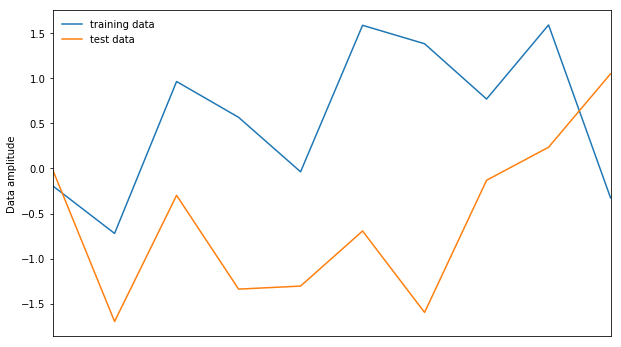

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(data['x_central'][np.random.randint(n_train * n_s)], label = "training data")
ax.plot(data['x_central_test'][np.random.randint(n_s)], label = "test data")
ax.legend(frameon = False)
ax.set_xlim([0, 9])
ax.set_xticks([])
ax.set_ylabel("Data amplitude");

It is also very useful to plot the upper and lower derivatives to check that the sample variance is actually supressed since the network learns extremely slowly if this isn't done properly.

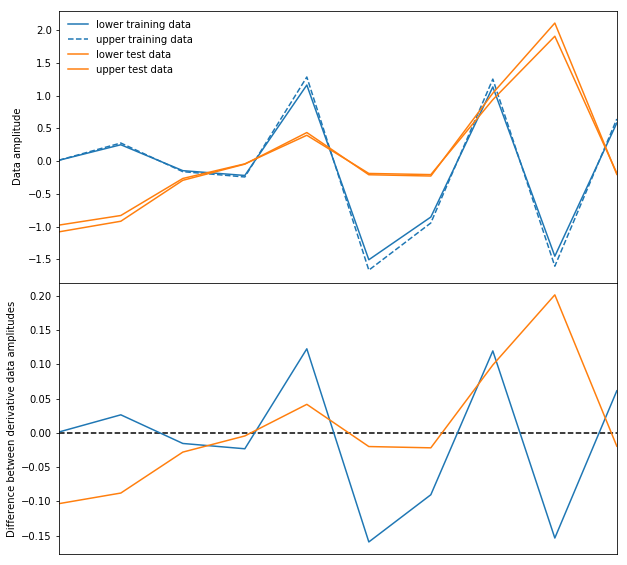

In [13]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
plt.subplots_adjust(hspace = 0)
training_index = np.random.randint(n_train * n_p)
ax[0].plot(data['x_m'][training_index, 0], label = "lower training data", color = 'C0')
ax[0].plot(data['x_p'][training_index, 0], label = "upper training data", color = 'C0', linestyle = 'dashed')
test_index = np.random.randint(n_p)
ax[0].plot(data['x_m_test'][test_index, 0], label = "lower test data", color = 'C1')
ax[0].plot(data['x_p_test'][test_index, 0], label = "upper test data", color = 'C1')
ax[0].legend(frameon = False)
ax[0].set_xlim([0, 9])
ax[0].set_xticks([])
ax[0].set_ylabel("Data amplitude")
ax[1].axhline(xmin = 0., xmax = 1., y = 0., linestyle = 'dashed', color = 'black')
ax[1].plot(data['x_p'][training_index, 0] - data['x_m'][training_index, 0], color = 'C0')
ax[1].plot(data['x_p_test'][test_index, 0] - data['x_m_test'][test_index, 0], color = 'C1')
ax[1].set_xlim([0, 9])
ax[1].set_xticks([])
ax[1].set_ylabel("Difference between derivative data amplitudes");

### Data for covariance regularisation

We can use the covariance of a set of randomly drawn simulations as a regulariser in the loss function to prevent the covariance of the fiducial parameters collapsing. To do this we create a set of simulations drawn from a Gaussian prior.

In [34]:
num_check_sim = 100
check_covariance = np.array([[0.1]])

In [15]:
θ_check = np.random.multivariate_normal([θ_fid], check_covariance, num_check_sim)
failed_draw = np.where(θ_check <= 0)
while len(failed_draw[0]) > 0:
    θ_check[failed_draw[0]] = np.random.multivariate_normal([θ_fid], check_covariance, len(failed_draw[0]))
    failed_draw = np.where(θ_check <= 0)
θ_check = θ_check.reshape((num_check_sim))
check_sims = generate_data(θ_check)
data["x_check"] = check_sims

## Initiliase the neural network
### Define network parameters
The network works with a base set of parameters which are<br>
> `'verbose'` - `bool` - whether to print out diagnostics

> `'number of simulations'` - `int` - the number of simulations to use in any one combination

> `'differentiation fraction'` - `float` - a fraction of the simulations to use for the numerical derivative

> `'fiducial θ'` - `array` - fiducial parameters in an array

> `'derivative denominator'` - `array` - denominator of the numerical derivative for each parameter

> `'number of summaries'` - `int` - number of summaries the network makes from the data

> `'input shape'` - `int` or `list` - the number of inputs or the shape of the input if image-like input

> `'preload data'` - `dict` or `None` - the training (and test) data to preload as a TensorFlow constant in a dictionary, no preloading is done if `None`

> `'calculate MLE'` - `bool` - whether to calculate the maximum likelihood estimate

> `'covariance regularisation'` - `bool` - whether to regularise the loss using the covariance of some parameters

> `'prebuild'` - `bool` - whether to get the network to build a network or to provided your own

> `'save file'` - `string` - a file name to save the graph (not saved if wrong type or not given)

```python
parameters = {
    'verbose': True,
    'number of simulations': n_s,
    'differentiation fraction': derivative_fraction,
    'fiducial θ': np.array([θ_fid]),
    'derivative denominator': der_den,
    'number of summaries': 1,
    'input shape': input_shape,
    'preload data': data,
    'calculate MLE': True,
    'prebuild': False,
}
```
The module can also build simple convolutional or dense networks (or a mixture of the two), which can be trigger by setting `'prebuild': True`. Several parameters are required to allow the network to build the network. These are<br>
> `'wv'` - `float` - the variance with which to initialise the weights. If this is 0 or less, the network will determine the weight variance according to He initialisation

> `'bb'` - `float` - the constant value with which to initialise the biases

> `'activation'` - `TensorFlow function` - a native tensorflow activation function

> `'α'` - `float` or `int` - an additional parameter, if needed, for the tensorflow activation function

> `'hidden layers'` - `list` - the architecture of the network. each element of the list is a hidden layer. A dense layer can be made using an integer where thet value indicates the number of neurons. A convolutional layer can be built by using a list where the first element is an integer where the number describes the number of filters, the second element is a list of the kernel size in the x and y directions, the third elemnet is a list of the strides in the x and y directions and the final element is string of 'SAME' or 'VALID' which describes the padding prescription.

If `covariance regularisation` is `True` then `get_MLE` must be set to `True` and two more parameters are needed in the dictionary<br>
> `'number of simulations for covariance regularisation'` - `int` - the number of simulations to approximate the covariance for regularisation

> `'comparison covariance'` - `array` - a numpy array of the proposal covariance where the simulations for checking were made

Here is an example of the IMNN which uses 1000 simulations per combination and 50 upper and 50 lower simulations per derivative for a model with one parameter where we require one summary which are preloaded as a TensorFlow constant where we want to have access to the precomputed maximum likelihood estimate. The module will build the network which takes in an input array of shape `[10]` and allows the network to decide the weight initialisation, initialises the biases at `bb = 0.1` and uses `tf.nn.leaky_relu` activation with a negative gradient parameter of `α = 0.01`. We will use covariance regularisation.  The network architecture has two fully connected hidden layers with 128 neurons in each layer. The graph is saved into a file in the `data` folder called `model.meta`.

In [16]:
parameters = {
    'verbose': True,
    'number of simulations': n_s,
    'fiducial θ': np.array([θ_fid]),
    'derivative denominator': der_den,
    'differentiation fraction': derivative_fraction,
    'number of summaries': 1,
    'calculate MLE': True,
    'covariance regularisation': True,
    'number of simulations for covariance regularisation': num_check_sim,
    'comparison covariance': check_covariance,
    'prebuild': True,
    'input shape': input_shape,
    'preload data': data,
    'save file': "data/model",
    'wv': 0.,
    'bb': 0.1,
    'activation': tf.nn.leaky_relu,
    'α': 0.01,
    'hidden layers': [128, 128]
}

### Self-defined network
A self defined network can be used instead of letting the module build the network for you. This function needs to take in two input tensors, the first is the shape of the input with `None` in the first axis and the second tensor is a tensorflow float (which will be the dropout). Since the weights need to be shared between several corresponding networks each set of trainable variables must be defined in its own scope. An example of the above network defined outside of the module is
```python
def network(input_tensor, dropout):
    with tf.variable_scope('layer_1'):
        weights = tf.get_variable("weights", [10, 128], initializer = tf.random_normal_initializer(0., 1.))
        biases = tf.get_variable("biases", [128], initializer = tf.constant_initializer(0.1))
    x = tf.matmul(input_tensor, weights)
    x = tf.add(x, biases)
    x = tf.nn.leaky_relu(x, 0.01)
    x = tf.nn.dropout(x, dropout)
    with tf.variable_scope('layer_2'):
        weights = tf.get_variable("weights", [128, 128], initializer = tf.random_normal_initializer(0., 1.))
        biases = tf.get_variable("biases", [128], initializer = tf.constant_initializer(0.1))
    x = tf.matmul(x, weights)
    x = tf.add(x, biases)
    x = tf.nn.leaky_relu(x, 0.01)
    x = tf.nn.dropout(x, dropout)
    x = tf.reshape(x, (-1, 300))
    with tf.variable_scope('layer_3'):
        weights = tf.get_variable("weights", [128, 1], initializer = tf.random_normal_initializer(0., np.sqrt(2. / 300)))
        biases = tf.get_variable("biases", [1], initializer = tf.constant_initializer(0.1))
    x = tf.matmul(x, weights)
    x = tf.add(x, biases)
    x = tf.nn.leaky_relu(x, 0.01)
    x = tf.nn.dropout(x, dropout)
    return x
```

### Initialise the network

In [17]:
n = IMNN.IMNN(parameters = parameters)

saving model as data/model.meta
network architecture is [[10], 128, 128, 1].


### Build the network
To build the network a learning rate, η, must be defined.

In [18]:
η = 1e-3

The `setup(η)` function initialises the input tensors, builds the network and defines the optimisation scheme. If a self-defined network function (`network(a, b)`) has been constructed this can be passed to the setup function
```python
n.setup(η = η, network = network)
```

In [19]:
print(n.comparison_C)
n.setup(η = η)

[[0.1]]
Tensor("x:0", shape=(?, 10), dtype=float32)
Tensor("IMNN/layer_1/dense_1/mul:0", shape=(?, 128), dtype=float32)
Tensor("IMNN/layer_2/dense_2/mul:0", shape=(?, 128), dtype=float32)
Tensor("IMNN/layer_3/LeakyRelu:0", shape=(?, 1), dtype=float32)
Tensor("output:0", shape=(?, 1), dtype=float32)
Tensor("GatherNd:0", shape=(1000, 10), dtype=float32)
Tensor("IMNN_1/layer_1/dense_1/mul:0", shape=(1000, 128), dtype=float32)
Tensor("IMNN_1/layer_2/dense_2/mul:0", shape=(1000, 128), dtype=float32)
Tensor("IMNN_1/layer_3/LeakyRelu:0", shape=(1000, 1), dtype=float32)
Tensor("Reshape:0", shape=(50, 10), dtype=float32)
Tensor("IMNN_1/layer_1_1/dense_1/mul:0", shape=(50, 128), dtype=float32)
Tensor("IMNN_1/layer_2_1/dense_2/mul:0", shape=(50, 128), dtype=float32)
Tensor("IMNN_1/layer_3_1/LeakyRelu:0", shape=(50, 1), dtype=float32)
Tensor("Reshape_1:0", shape=(50, 10), dtype=float32)
Tensor("IMNN_1/layer_1_2/dense_1/mul:0", shape=(50, 128), dtype=float32)
Tensor("IMNN_1/layer_2_2/dense_2/mul:0"

### Changing minimisation scheme
By default the optimation scheme is<br>
```python
n.backpropagate = tf.train.AdamOptimizer(η, β1, β2, ε).minimize(n.loss(n.F))
```
where β1, β2 and ε are left at their default values. To use any other training scheme, such as the `SGD` optimiser, it is sufficient to run
```python
n.backpropagate = tf.train.GradientDescentOptimizer(η).minimize(n.loss(n.F))
```
after `setup(η)` to override the default minimisation routine. If you want to continue to use the default minimisation routine but want to change the learning rate without reinitialising you can run 
```python
n.training_scheme(η = new_η)
```

## Train the network
With the data we can now train the network. The function simply takes the number of epochs, `num_epochs`, the fraction of neurons kept when using dropout `keep_rate`, and the denominator for the derivative calculated earlier, `der_den`.

In [20]:
num_epochs = 500
keep_rate = 0.8

If the data has not been preloaded as a TensorFlow constant then it can be passed to the train function
```python
train_F, test_F = n.train(num_epochs = num_epochs, n_train = n_train, keep_rate = keep_rate, data = data)
```
We can run

In [21]:
train_F, test_F = n.train(num_epochs = num_epochs, n_train = n_train, keep_rate = keep_rate, data = data)

100%|██████████| 500/500 [00:11<00:00, 45.06it/s, detF=6.96, detF_test=3.9]  

saving the graph as data/model.meta


The train function returns a list of the determinant of the Fisher matrix on the training data, and a second list for the test data if available.</br></br>
The outputs from the train function can be plotted, along with the loss function which is simply
$$\Lambda = -\frac{1}{2}|F|^2.$$

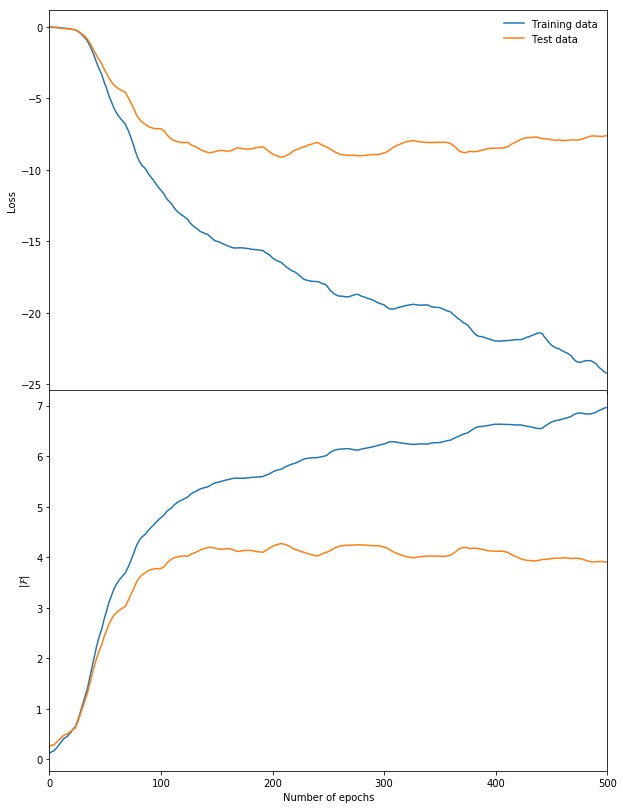

In [22]:
train_F = np.array(train_F)
test_F = np.array(test_F)
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10, 14))
plt.subplots_adjust(hspace = 0)
end = len(train_F)
epochs = np.arange(end)
a, = ax[0].plot(epochs, -0.5 * train_F[:end]**2, label = 'Training data')
b, = ax[0].plot(epochs, -0.5 * test_F[:end]**2, label = 'Test data')
ax[0].legend(frameon = False)
ax[0].set_ylabel('Loss')
ax[1].plot(epochs, train_F[:end])
ax[1].plot(epochs, test_F[:end])
ax[1].set_ylabel('$|\mathcal{F}|$')
ax[1].set_xlabel('Number of epochs')
ax[1].set_xlim([0, len(epochs)]);

We can see that the test loss deviates from the training loss. This is to be expected because there are will be a lot of correlation within a small training set which isn't in the test set. As long as the test loss doesn't start increasing then it is likely that the network is still working, with the maximum Fisher available from the network is the value obtained from the test set.

## Resetting the network
If you need to reset the weights and biases for any reason then you can call
```python
n.reinitialise_session()
```

## Saving the network

If you don't initialise the network with a save name you can save the network as a `TensorFlow` `meta` graph. For example saving the model in the directory `/.data` called `saved_model.meta` can be done using the function
```python
n.save_network(file_name = "data/saved_model", first_time = True)
```
If `save file` is passed with a correct file name when initialising the module then the initialised network will be saved by
```python
n.begin_session()
```
and then saved at the end of training.

## Loading the network

You can load the network from a `TensorFlow` `meta` graph (from `/.data/saved_model.meta`) using the same parameter dictionary as used when originally training the network and then running
```python
n = IMNN.IMNN(parameters = parameters)
n.restore_network()
```
Training can be continued after restoring the model - although the Adam optimiser might need to reacquaint itself.

## Approximate Bayesian computation
We can now do ABC (or PMC-ABC) with our calculated summary. First we generate some simulated real data:

In [23]:
real_data = generate_data(θ = [1.], train = False)

We can plot this real data to see what it looks like.

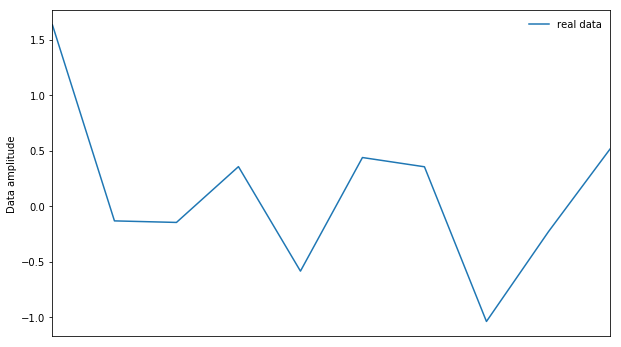

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(real_data[0], label = "real data")
ax.legend(frameon = False)
ax.set_xlim([0, 9])
ax.set_xticks([])
ax.set_ylabel("Data amplitude");

### ABC
We now perform ABC by drawing 100000 random samples from the prior. We define the upper and lower bounds of a uniform prior to be 0 and 10. Only a uniform prior is implemented at the moment. From the samples we create simulations at each parameter value and feed each simulation through the network to get summaries. The summaries are compared to the summary of the real data to find the distances which can be used to accept or reject points.
Because the simulations are created within the ABC function then the generation function must be passed. This is why the generator should be of the form defined above, which takes only a list of parameter values and returns a simulation at each parameter.

If the data is not preloaded as a TensorFlow constant then the data can be passed to the function as
```python
θ, summary, s, ρ, F = n.ABC(real_data = real_data, prior = [0, 10], draws = 100000, generate_simulation = generate_data, at_once = True, data = data)
```
Here we can use

In [25]:
θ, summary, s, ρ, F = n.ABC(real_data = real_data, prior = [0, 10], draws = 100000, generate_simulation = generate_data, at_once = True, data = data)

If the simulations are going to be too large to make all at once the `at_once` option can be set to false which will create one simulation at a time.
```python
θ, summary, s, ρ, F = n.ABC(real_data = real_data, der_den = der_den, prior = [0, 10], draws = 100000, generate_simulation = generate_data, at_once = False)
```

### Accept or reject
In ABC draws are accepted if the distance between the simulation summary and the simulation of the real data are "close", i.e. smaller than some ϵ value, which is chosen somewhat arbitrarily.

In [26]:
ϵ = 1
accept_indices = np.argwhere(ρ < ϵ)[:, 0]
reject_indices = np.argwhere(ρ >= ϵ)[:, 0]

### Plot samples
We can plot the output samples and the histogram of the accepted samples, which should peak around `θ = 1` (where we generated the real data). The monotonic function of all the output samples shows that the network has learned how to summarise the data.

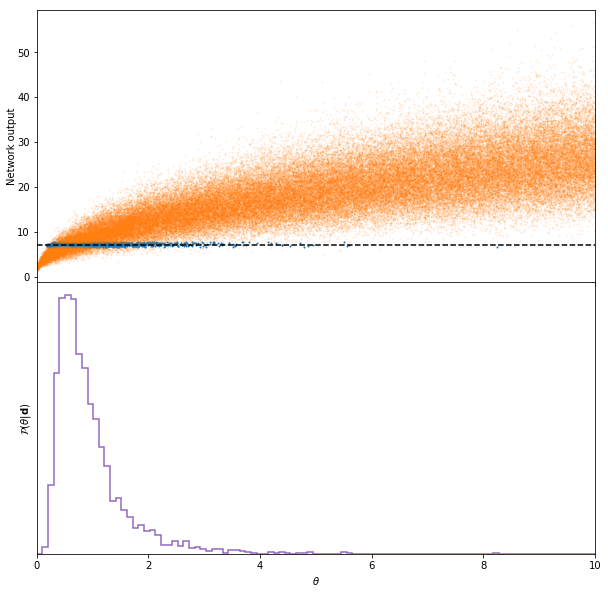

In [27]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10, 10))
plt.subplots_adjust(hspace = 0)
ax[0].scatter(θ[accept_indices] , s[accept_indices, 0], s = 1)
ax[0].scatter(θ[reject_indices], s[reject_indices, 0], s = 1, alpha = 0.1)
ax[0].plot([0, 10], [summary[0], summary[0]], color = 'black', linestyle = 'dashed')
ax[0].set_ylabel('Network output', labelpad = 0)
ax[0].set_xlim([0, 10])
ax[1].hist(θ[accept_indices], np.linspace(0, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = '#9467bd');
ax[1].set_xlabel('$\\theta$')
ax[1].set_ylabel('$\\mathcal{P}(\\theta|{\\bf d})$')
ax[1].set_yticks([]);

There can be a lot of $\theta$ draws which are unconstrained by the network because no similar structures were seen in the data which is indicative of using too small of a small training set.

## PMC-ABC
Population Monte Carlo ABC is a way of reducing the number of draws by first sampling from a prior, accepting the closest 75% of the samples and weighting all the rest of the samples to create a new proposal distribution. The furthest 25% of the original samples are redrawn from the new proposal distribution. The furthest 25% of the simulation summaries are continually rejected and the proposal distribution updated until the number of draws needed accept all the 25% of the samples is much greater than this number of samples. This ratio is called the criterion. The inputs work in a very similar way to the `ABC` function above. If we want 1000 samples from the approximate distribution at the end of the PMC we need to set `num_keep = 1000`. The initial random draw (as in ABC above) initialises with `num_draws`, the larger this is the better proposal distribution will be on the first iteration.

If the data is not preloaded as a TensorFlow constant then the data can be passed to the function as
```python
θ_, summary_, ρ_, s_, W, total_draws, F = n.PMC(real_data = real_data, prior = [0, 10], num_draws = 1000, num_keep = 1000, generate_simulation = generate_data, criterion = 0.1, data = data, at_once = True, samples = None)```
Here we can use

In [28]:
θ_, summary_, ρ_, s_, W, total_draws, F = n.PMC(real_data = real_data, prior = [0, 10], num_draws = 1000, num_keep = 1000, generate_simulation = generate_data, criterion = 0.1, at_once = True, samples = None, data = data)

If we want the PMC to continue for longer we can provide the output of PMC as an input as
```python
θ_, summary_, ρ_, s_, W, total_draws, F = n.PMC(real_data = real_data, der_den = der_den, prior = [0, 10], num_draws = 1000, num_keep = 1000, generate_simulation = generate_data, criterion = 0.01, data = data, at_once = True, samples = [θ_, summary_, ρ_, s_, W, total_draws, F])```

Finally we can plot the accepted samples and plot their histogram.

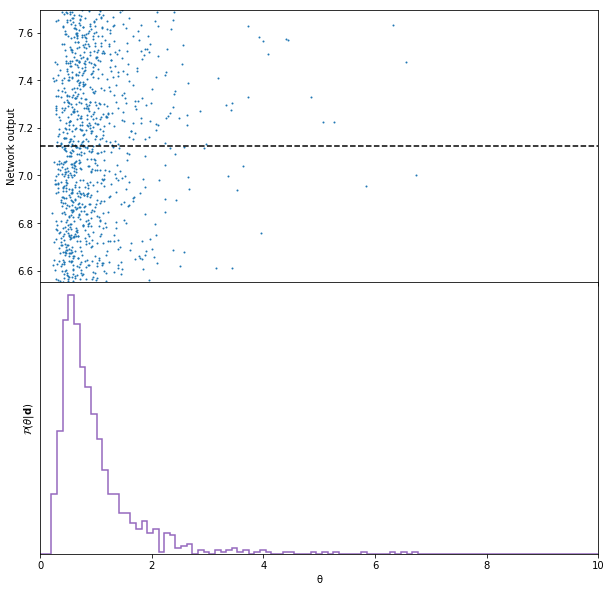

In [29]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (10, 10))
plt.subplots_adjust(hspace = 0)
ax[0].scatter(θ_ , s_, s = 1)
ax[0].plot([0, 10], [summary[0], summary[0]], color = 'black', linestyle = 'dashed')
ax[0].set_ylabel('Network output', labelpad = 0)
ax[0].set_xlim([0, 10])
ax[0].set_ylim([np.min(s_), np.max(s_)])
ax[1].hist(θ_, np.linspace(0, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = '#9467bd');
ax[1].set_xlabel('θ')
ax[1].set_ylabel('$\\mathcal{P}(\\theta|{\\bf d})$')
ax[1].set_yticks([]);

## Maximum likelihood estimate

We can also calculate the first-order Gaussian approximation of the posterior on the parameter and find a maximum likelihood estimate.

If the data is not preloaded as a TensorFlow constant then it can be passed using
```python
asymptotic_likelihood = n.asymptotic_likelihood(real_data = real_data, prior = np.linspace(0, 10, 1000).reshape((1, 1, 1000)), data = data)
MLE = n.θ_MLE(real_data = real_data, data = data)
```

Here we will use 

In [30]:
asymptotic_likelihood = n.asymptotic_likelihood(real_data = real_data, prior = np.linspace(0, 10, 1000).reshape((1, 1, 1000)), data = data)
MLE = n.θ_MLE(real_data = real_data, data = data)

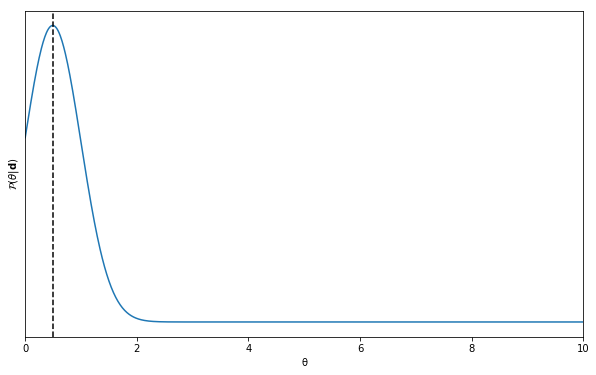

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(np.linspace(0, 10, 1000), asymptotic_likelihood[0, 0], linewidth = 1.5)
ax.axvline(x = MLE[0, 0], ymin = 0., ymax = 1., linestyle = 'dashed', color = 'black')
ax.set_xlabel("θ")
ax.set_xlim([0, 10])
ax.set_ylabel('$\\mathcal{P}(\\theta|{\\bf d})$')
ax.set_yticks([]);

## Analytic posterior calculation

We know what the analytic posterior is for this model
$$\mathcal{P}(\boldsymbol{\theta}|{\bf d}) = \frac{\displaystyle{\rm exp}\left[-\frac{1}{2\boldsymbol{\theta}}\sum_{i = 1}^{n_{\bf d}}d_i\right]}{(2\pi\boldsymbol{\theta})^{n_{\bf d}/2}}.$$
We can there for plot this as a comparison.

In [32]:
θ_grid = np.linspace(0.001, 10, 1000)
analytic_posterior = np.exp(-0.5 * np.sum(real_data**2.) / θ_grid) / np.sqrt(2. * np.pi * θ_grid)**10.
analytic_posterior = analytic_posterior / np.sum(analytic_posterior * (θ_grid[1] - θ_grid[0]))

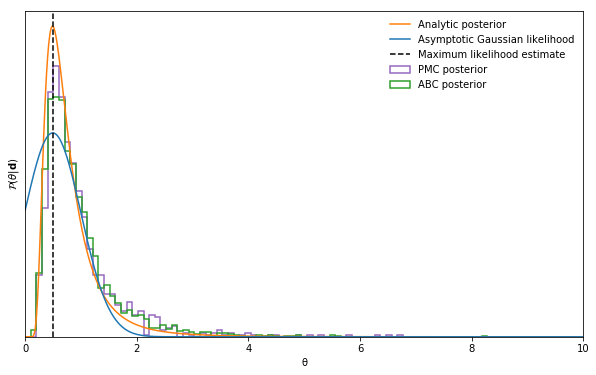

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(θ_grid, analytic_posterior, linewidth = 1.5, color = 'C1', label = "Analytic posterior")
ax.hist(θ_, np.linspace(0, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = '#9467bd', label = "PMC posterior");
ax.hist(θ[accept_indices], np.linspace(0, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = 'C2', label = "ABC posterior")
ax.plot(np.linspace(0, 10, 1000), asymptotic_likelihood[0, 0], color = 'C0', linewidth = 1.5, label = "Asymptotic Gaussian likelihood")
ax.axvline(x = MLE[0, 0], ymin = 0., ymax = 1., linestyle = 'dashed', color = 'black', label = "Maximum likelihood estimate")
ax.legend(frameon = False)
ax.set_xlim([0, 10])
ax.set_xlabel('θ')
ax.set_ylabel('$\\mathcal{P}(\\theta|{\\bf d})$')
ax.set_yticks([]);